In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

In [4]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils import data
import torchvision

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import math
from tqdm import tqdm

### Useful sites:
1. [Torch-Uncertainty Library](https://github.com/ensta-u2is/torch-uncertainty)
   - A library for uncertainty estimation in deep learning, including deep learning baselines like Deep Ensembles, MC-Dropout, and more. The repository also provides tutorials.

2. [Awesome Uncertainty Deep Learning Repository](https://github.com/ENSTA-U2IS/awesome-uncertainty-deeplearning)
   - A collection of papers and resources related to Uncertainty and Deep Learning.

3. [Paper on Uncertainty Estimation](https://cds.cern.ch/record/2837844/files/2210.09767.pdf)
   - A paper from HSE describing how uncertainty estimation was applied to a GAN task in a physics experiment, specifically the LHCb experiment.


### Prepare test dataset

In [276]:
train_data_length = 1024
train_data_length_certain = 800 
train_data_length_uncertain = train_data_length - train_data_length_certain
train_data = torch.zeros((train_data_length, 1))
train_data[:train_data_length_certain, 0] = 1.5 * math.pi * torch.rand(train_data_length_certain)
train_data[train_data_length_certain:, 0] = 2 * math.pi * torch.rand(train_data_length_uncertain)
# train_data[:, 1] = torch.sin(train_data[:, 0])
train_data = [train_data]
# train_data.append(torch.sin(train_data[0][:, 0]))
train_data.insert(0, torch.sin(train_data[0][:, 0]))
# train_data[1] = torch.sin(train_data[:, 0])
# train_labels = torch.zeros(train_data_length)
# train_set = [
#     (train_data[i], train_labels[i]) for i in range(train_data_length)
# ]

In [277]:
from torch.utils.data import Dataset

class MyDataset(Dataset):
    def __init__(self, train_data):
        self.data = train_data

    def __len__(self):
        return len(self.data[0])

    def __getitem__(self, idx):
        x = self.data[0][idx]
        y = self.data[1][idx]
        return x, y

In [278]:
my_dataset = MyDataset(train_data)

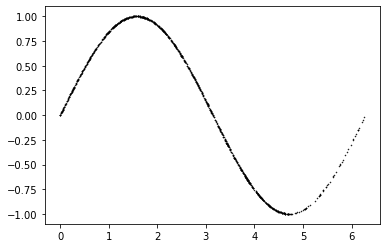

In [292]:
plt.plot(train_data[1], train_data[0], 'ko', markersize=0.5)

In [293]:
BATCH_SIZE = 32
train_loader = torch.utils.data.DataLoader(
    my_dataset, batch_size=BATCH_SIZE, shuffle=True
)

### GAN architecture
>start with basic simple cGAN

Define the GAN

>The GAN is designed such that a random latent number or vector is concatenated with a given variable 'x.' The GAN is then trained to learn the mapping from this combined input to the target variable 'y,' where 'y' is defined as the sine of 'x'

In [ ]:
from unceratinty.models import Base_Discriminator, Base_Generator


In [399]:
#Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid(),
        )

    def forward(self, x, info):
        x = torch.cat([x, info], 1)
        output = self.model(x)
        return output

In [594]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 16),#2 = 1(space_dim/noise_dim) + 1(additional info, x)
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
        )

    def forward(self, x, info):
        x = torch.cat([x, info], 1)
        output = self.model(x)
        return output
    

In [630]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [725]:
D = Discriminator().to(device=device)
G = Generator().to(device=device)

In [726]:
#model parametrs
# learning_rate_G = 0.0001
# learning_rate_D = 0.0004
lr = 0.001
NUM_EPOCHS = 200
loss_function = nn.BCELoss()

In [727]:
D_optimizer = torch.optim.Adam(D.parameters(), lr=lr)
G_optimizer = torch.optim.Adam(G.parameters(), lr=lr)
# D_optimizer = optim.Adam(D.parameters(), lr=learning_rate_G, betas=(0.5, 0.999))
# G_optimizer = optim.Adam(G.parameters(), lr=learning_rate_D, betas=(0.5, 0.999))

Train Discriminator

In [728]:
def D_train(
        x,
        info,
        D = D,
        G = G,
        D_optimizer = D_optimizer,
        criterion = loss_function,
        device = device,
        space_dimension = 1,
        noise_dim = 1
):
    D.zero_grad()

    # Train discriminator on real data
    x_real, y_real = x.view(-1, space_dimension).to(device), torch.ones(x.size(0), 1).to(device)  # 1 is real
    # print(x_real, y_real, info)
    D_output = D(x_real, info.view(-1, 1))
    D_real_loss = criterion(D_output, y_real)
    D_real_score = D_output

    # Train discriminator on fake data
    with torch.no_grad():
        z = torch.randn(x.size(0), noise_dim).to(device)
        fake_info = 2 * math.pi * torch.rand(x.size(0)).view(-1, 1).to(device)
    x_fake, y_fake = G(z, fake_info).view(-1, space_dimension), torch.zeros(x.size(0), 1).to(device)  # 0 is fake
    D_output = D(x_fake, fake_info)
    D_fake_loss = criterion(D_output, y_fake)
    # print(D_output, y_fake)
    D_fake_score = D_output

    # Calculate the total discriminator loss
    D_loss = D_real_loss + D_fake_loss

    # Backpropagate and optimize ONLY D's parameters
    D_loss.backward()
    D_optimizer.step()

    return D_loss.item()


Train Generator

In [729]:
def G_train(
        x,
        D = D,
        G = G,
        D_optimizer = D_optimizer,
        criterion = loss_function,
        device = device,
        space_dimension = 1,
        noise_dim = 1
):
    G.zero_grad()
    z = torch.randn(x.size(0), noise_dim).to(device)
    y = torch.ones(x.size(0), 1).to(device)
    
    # random_values = np.random.uniform(0, 2 * math.pi, x.size(0))
    # fake_info = torch.tensor(random_values, dtype=torch.float32).view(-1, 1).to(device)
    fake_info = 2 * math.pi * torch.rand(x.size(0)).view(-1, 1).to(device)
    G_output = G(z, fake_info).view(-1, space_dimension)
    D_output = D(G_output, fake_info)
    
    G_loss = criterion(D_output, y.to(device))

    # gradient backprop & optimize ONLY G's parameters
    G_loss.backward()
    G_optimizer.step()
        
    return G_loss.data.item()


### Training

In [730]:
batches_per_epoch = train_data_length//BATCH_SIZE
batches_per_epoch

32

In [731]:
from optimal_batch import create_batch, calculate_variance

In [732]:
NUM_EPOCHS = 200

In [733]:
D_losses_final = []
G_losses_final = []
Variances = []
# NUM_EPOCHS = NUM_EPOCHS//10
for epoch in tqdm(range(1, NUM_EPOCHS+1)):           
    D_losses, G_losses = [], []
    for batch_idx in range(batches_per_epoch):
        batch, mean_var = create_batch(
                                Generator = G,
                                batch_size = BATCH_SIZE,
                                get_variance = True,
                                repeat = 10,
                                num_samples = 128
                            )
        x, info = batch#x is y coordiante, we predict it, info is x corrdinate, its condition
        D_losses.append(D_train(x, info))
        G_losses.append(G_train(x))
        Variances.append(mean_var)
        # print(len(batch), var, x.size(), info.size())
        # print(var)
        # break
    
    # for batch_idx, (x, info) in enumerate(train_loader):
    #     D_losses.append(D_train(x, info))
    #     G_losses.append(G_train(x))
        
    D_losses_final.append(torch.mean(torch.FloatTensor(D_losses)))
    G_losses_final.append(torch.mean(torch.FloatTensor(G_losses)))
    
    if epoch % 20 == 0:
        print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
                (epoch),
                NUM_EPOCHS,
                torch.mean(torch.FloatTensor(D_losses)),
                torch.mean(torch.FloatTensor(G_losses))
                )
             )

 10%|████████████████▌                                                                                                                                                     | 20/200 [00:12<01:54,  1.58it/s]

[20/200]: loss_d: 1.089, loss_g: 1.051


 20%|█████████████████████████████████▏                                                                                                                                    | 40/200 [00:25<01:39,  1.61it/s]

[40/200]: loss_d: 1.065, loss_g: 2.092


 30%|█████████████████████████████████████████████████▊                                                                                                                    | 60/200 [00:37<01:27,  1.60it/s]

[60/200]: loss_d: 1.374, loss_g: 1.547


 40%|██████████████████████████████████████████████████████████████████▍                                                                                                   | 80/200 [00:50<01:15,  1.59it/s]

[80/200]: loss_d: 1.266, loss_g: 0.834


 50%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 100/200 [01:03<01:02,  1.60it/s]

[100/200]: loss_d: 0.989, loss_g: 2.012


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 120/200 [01:15<00:50,  1.57it/s]

[120/200]: loss_d: 1.035, loss_g: 2.703


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 140/200 [01:28<00:37,  1.58it/s]

[140/200]: loss_d: 1.281, loss_g: 2.492


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 160/200 [01:41<00:25,  1.54it/s]

[160/200]: loss_d: 0.739, loss_g: 3.426


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 180/200 [01:53<00:12,  1.58it/s]

[180/200]: loss_d: 1.018, loss_g: 1.951


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [02:06<00:00,  1.58it/s]

[200/200]: loss_d: 1.169, loss_g: 1.242


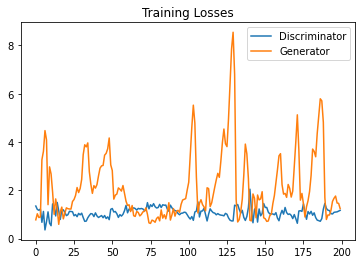

In [734]:
fig, ax = plt.subplots()
# losses = np.array(losses)
plt.plot(D_losses_final, label='Discriminator')
plt.plot(G_losses_final, label='Generator')
plt.title("Training Losses")
plt.legend()

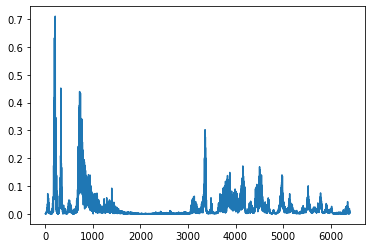

In [735]:
plt.plot(Variances)

## Test

In [736]:
# latent_space_samples = torch.randn(1000, 2)
num_samples = 10000
latent_space_samples = torch.randn(num_samples, 1)
# info = 8 * math.pi * torch.rand(num_samples).view(-1, 1) - 4 * math.pi
info = 2 * math.pi * torch.rand(num_samples).view(-1, 1)
generated_samples = G(latent_space_samples, info)



In [737]:
points_x, res = calculate_variance(G, repeat = 10, num_samples = 10000)

##### 4
> num_samples = 128, lr = 0.0005

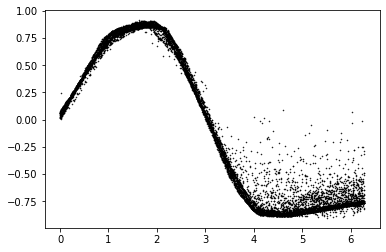

In [691]:
generated_samples = generated_samples.detach()
plt.plot(info, generated_samples, 'ko', markersize = 0.5)

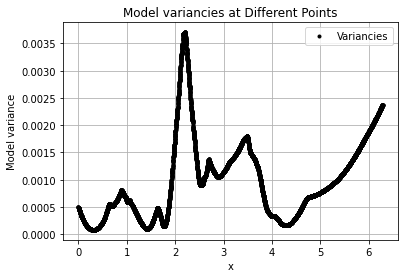

In [693]:
# Plot the graph
plt.plot(points_x, res, 'ko', markersize = 3, label='Variancies')
plt.xlabel('x')
plt.ylabel('Model variance')
plt.title('Model variancies at Different Points')
plt.legend()
plt.grid(True)
plt.show()

##### 3
> num_samples = 128

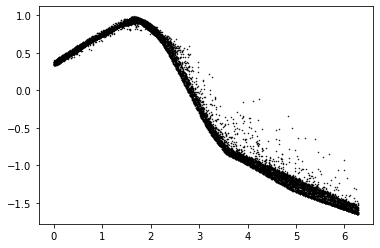

In [738]:
generated_samples = generated_samples.detach()
plt.plot(info, generated_samples, 'ko', markersize = 0.5)

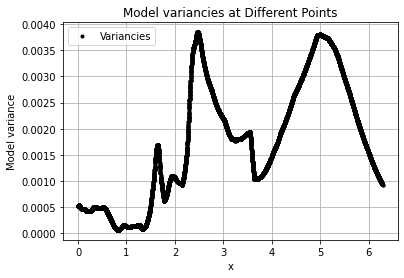

In [739]:
# Plot the graph
plt.plot(points_x, res, 'ko', markersize = 3, label='Variancies')
plt.xlabel('x')
plt.ylabel('Model variance')
plt.title('Model variancies at Different Points')
plt.legend()
plt.grid(True)
plt.show()

##### 2

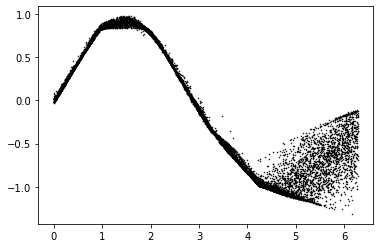

In [723]:
generated_samples = generated_samples.detach()
plt.plot(info, generated_samples, 'ko', markersize = 0.5)

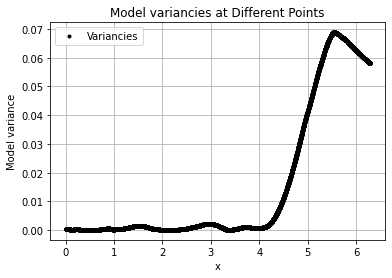

In [724]:
# Plot the graph
plt.plot(points_x, res, 'ko', markersize = 3, label='Variancies')
plt.xlabel('x')
plt.ylabel('Model variance')
plt.title('Model variancies at Different Points')
plt.legend()
plt.grid(True)
plt.show()

##### 1

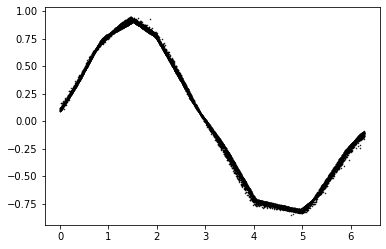

In [647]:
generated_samples = generated_samples.detach()
plt.plot(info, generated_samples, 'ko', markersize = 0.5)

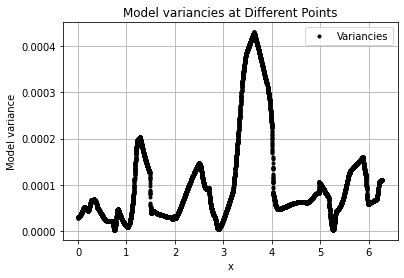

In [652]:
# Plot the graph
plt.plot(points_x, res, 'ko', markersize = 3, label='Variancies')
plt.xlabel('x')
plt.ylabel('Model variance')
plt.title('Model variancies at Different Points')
plt.legend()
plt.grid(True)
plt.show()

#### basic

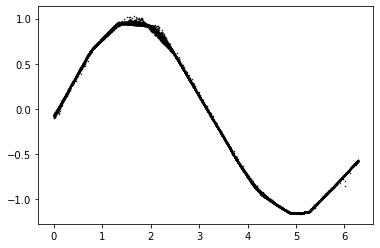

In [627]:
generated_samples = generated_samples.detach()
plt.plot(info, generated_samples, 'ko', markersize = 0.5)

In [628]:
points_x, res = calculate_variance(G, repeat = 1000, num_samples = 10000)

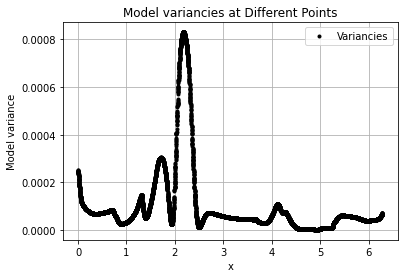

In [629]:
# Plot the graph
plt.plot(points_x, res, 'ko', markersize = 3, label='Variancies')
plt.xlabel('x')
plt.ylabel('Model variance')
plt.title('Model variancies at Different Points')
plt.legend()
plt.grid(True)
plt.show()

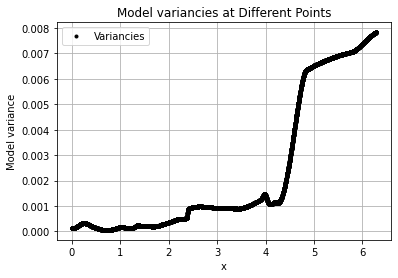

In [593]:
create_batch(G, batch_size = 10,                  
                 get_variance = True,
                 repeat = 10,
                 num_samples = 64)

([tensor([-0.5870, -0.5463, -0.4855, -0.3768, -0.2345, -0.1610, -0.1554, -0.1314,
          -0.1279, -0.0518]),
  tensor([[5.6558],
          [5.7053],
          [5.7763],
          [5.8969],
          [6.0465],
          [6.1215],
          [6.1272],
          [6.1514],
          [6.1550],
          [6.2314]])],
 0.0038968222012272236)